In [42]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2, mutual_info_regression, f_regression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest

In [2]:
ins_data = pd.read_pickle('../../data/feature engineered/insurance.pkl')
ins_data

,age,sex,bmi,children,smoker,region,charges
0,-0.854167,-1.0,-0.304319,-0.5,-0.590433,0.000000,0.475094
1,-1.020833,0.0,0.389592,0.0,0.000000,1.000000,-1.302772
2,-0.447917,0.0,0.302496,1.0,0.000000,1.000000,-0.585858
3,-0.239583,0.0,-0.987437,-0.5,0.000000,0.000000,0.692467
4,-0.281250,0.0,-0.183343,-0.5,0.000000,0.000000,-0.693955
...,...,...,...,...,...,...,...
1333,0.468750,0.0,0.067477,1.0,0.000000,0.000000,0.097725
1334,-1.020833,-1.0,0.178465,-0.5,0.000000,-0.025641,-1.119708
1335,-1.020833,-1.0,0.727647,-0.5,0.000000,1.000000,-1.345025
1336,-0.739583,-1.0,-0.571484,-0.5,0.000000,0.000000,-1.190043


In [7]:
Y = ins_data.loc[:, 'charges']
X = ins_data.drop('charges', axis=1)

In [8]:
X.shape, Y.shape

((1338, 6), (1338,))

****feature selection****

- Recursive feature elimination

In [33]:
rfcv_estimator = Ridge()
rfcv_model = RFECV(estimator=rfcv_estimator, step=1, cv=KFold(10))
rfcv_model.fit(X, Y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=Ridge())

In [35]:
rfcv_model.ranking_, rfcv_model.support_, rfcv_model.grid_scores_

(array([1, 1, 1, 1, 1, 1]),
 array([ True,  True,  True,  True,  True,  True]),
 array([0.45234756, 0.74089084, 0.75614481, 0.76219686, 0.76167365,
        0.76439415]))

In [32]:
rfcv_estimator_tree = DecisionTreeRegressor(min_samples_leaf=25)
rfcv_model_tree = RFECV(estimator=rfcv_estimator_tree, step=1, cv=KFold(10))
rfcv_model_tree.fit(X, Y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=DecisionTreeRegressor(min_samples_leaf=25))

In [37]:
rfcv_model_tree.ranking_, rfcv_model_tree.support_, rfcv_model_tree.grid_scores_

(array([1, 1, 1, 1, 1, 1]),
 array([ True,  True,  True,  True,  True,  True]),
 array([0.45239407, 0.77539503, 0.79750992, 0.82772253, 0.82679899,
        0.83201452]))

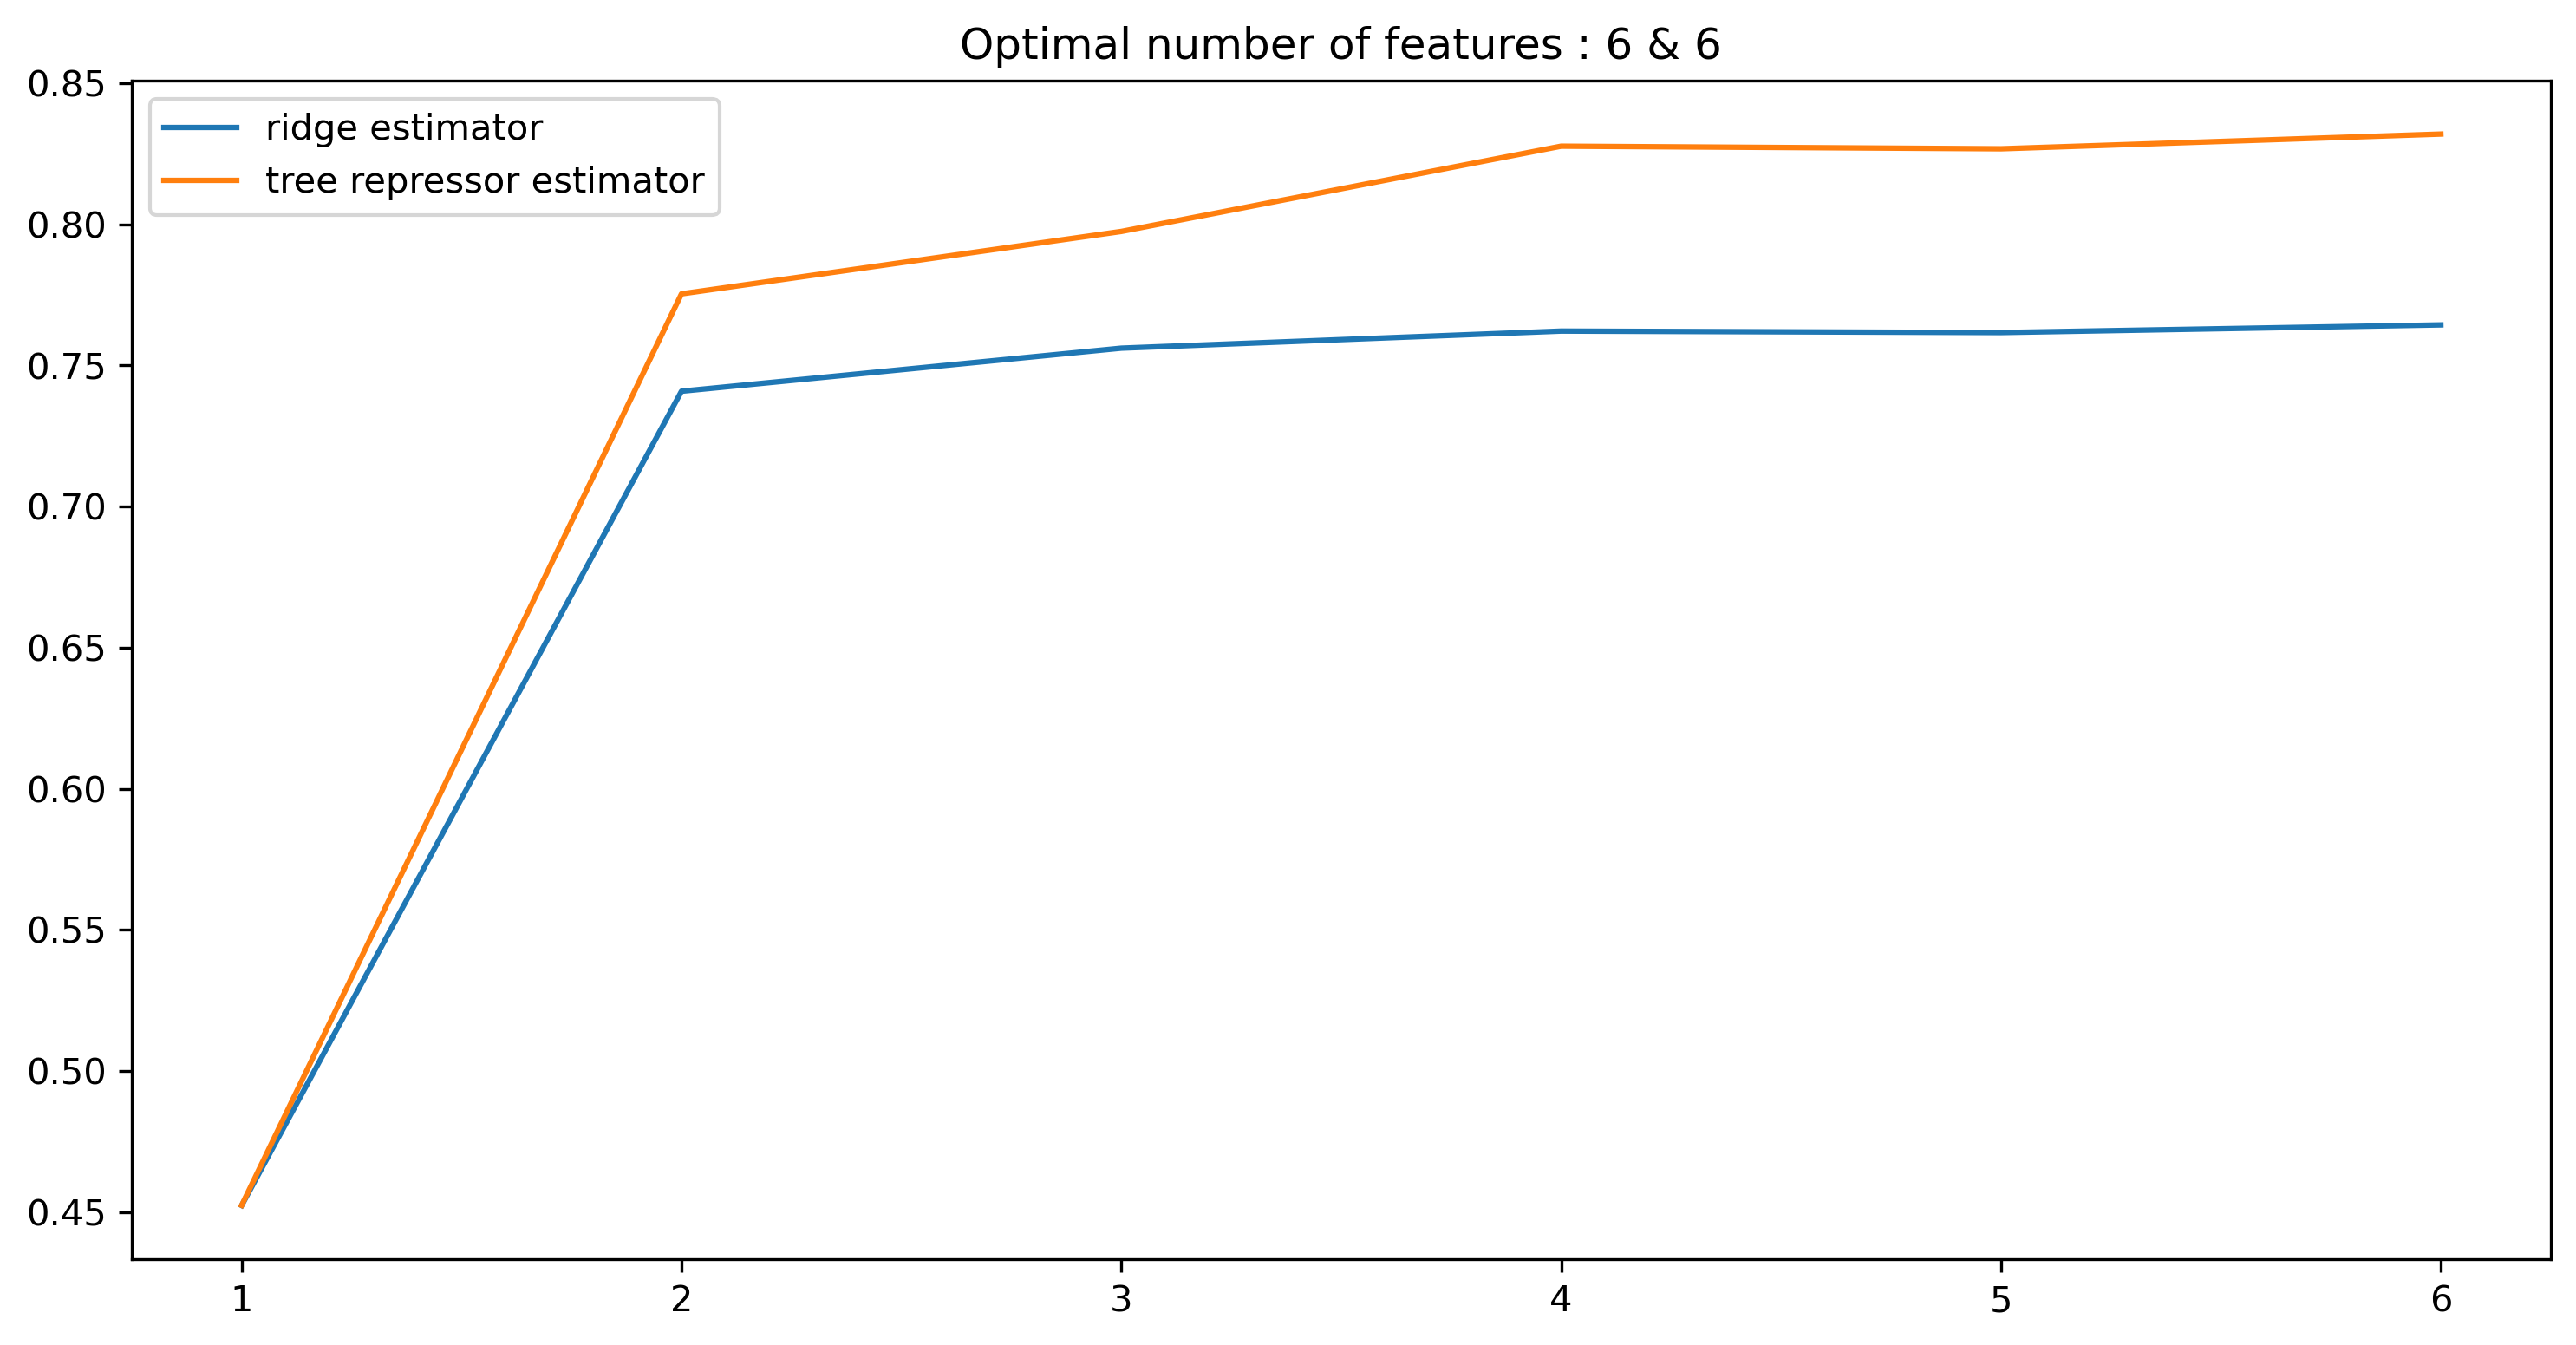

In [49]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(x=range(1, len(rfcv_model.grid_scores_) + 1), y=rfcv_model.grid_scores_,
             label='ridge estimator')
sns.lineplot(x=range(1, len(rfcv_model_tree.grid_scores_) + 1), y=rfcv_model_tree.grid_scores_,
             label='tree repressor estimator')
plt.legend()
plt.title(f'Optimal number of features : {rfcv_model.n_features_} & {rfcv_model_tree.n_features_}')
plt.savefig('../../demo/feature_selection_rfecv.png')
plt.show()

- Uni-variate feature selection

In [45]:
mireg_selection = SelectKBest(score_func=mutual_info_regression, k=4)
freg_selection = SelectKBest(score_func=f_regression, k=4)

mireg_selection.fit(X, Y)
freg_selection.fit(X, Y)

SelectKBest(k=4, score_func=<function f_regression at 0x0000025D7CF68598>)

In [46]:
mireg_selection.n_features_in_, mireg_selection.scores_, mireg_selection.pvalues_

(6,
 array([1.50452017, 0.17628529, 0.06986625, 0.16093565, 0.36938827,
        0.07861855]),
 None)

In [47]:
freg_selection.n_features_in_, freg_selection.scores_, freg_selection.pvalues_

(6,
 array([4.97690548e+02, 1.01006031e-01, 2.62708520e+01, 3.34596991e+01,
        1.12221960e+03, 4.24058966e-01]),
 array([5.73042765e-094, 7.50675347e-001, 3.40326645e-007, 9.05038846e-009,
        4.10149955e-179, 5.15030605e-001]))

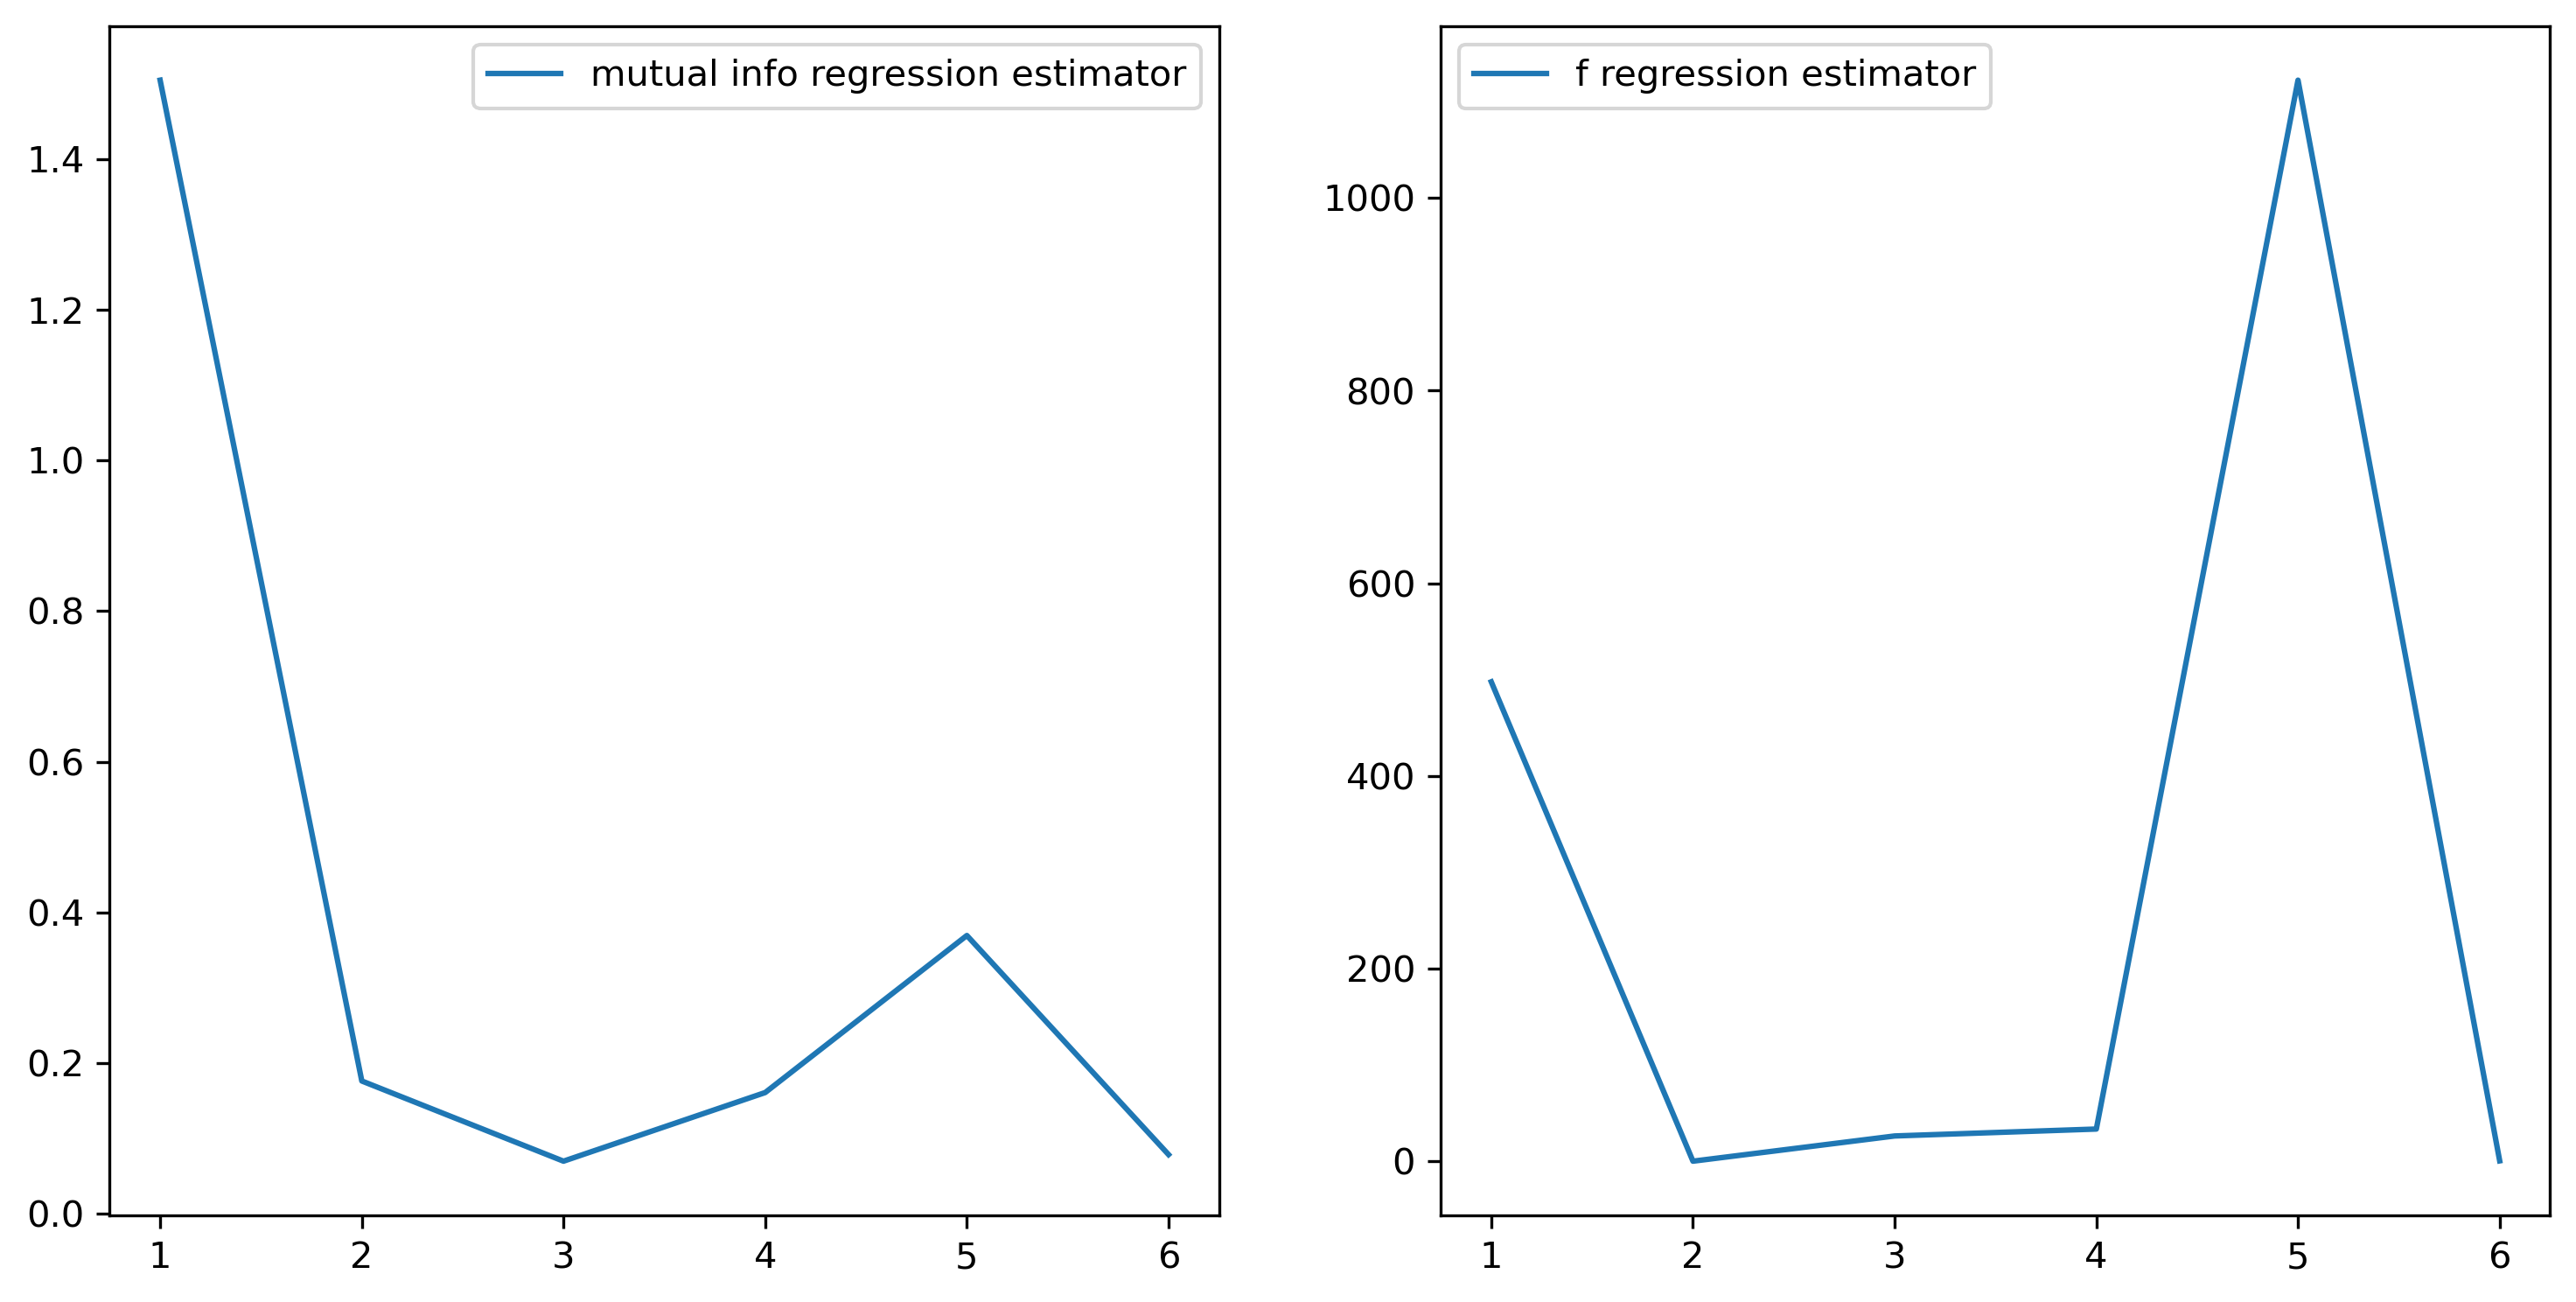

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=range(1, mireg_selection.n_features_in_ + 1),
             y=mireg_selection.scores_,
             label='mutual info regression estimator',
             ax=axes[0])
sns.lineplot(x=range(1, freg_selection.n_features_in_ + 1),
             y=freg_selection.scores_,
             label='f regression estimator',
             ax=axes[1])
plt.legend()
plt.savefig('../../demo/feature_selection_select_k_best.png')
plt.show()

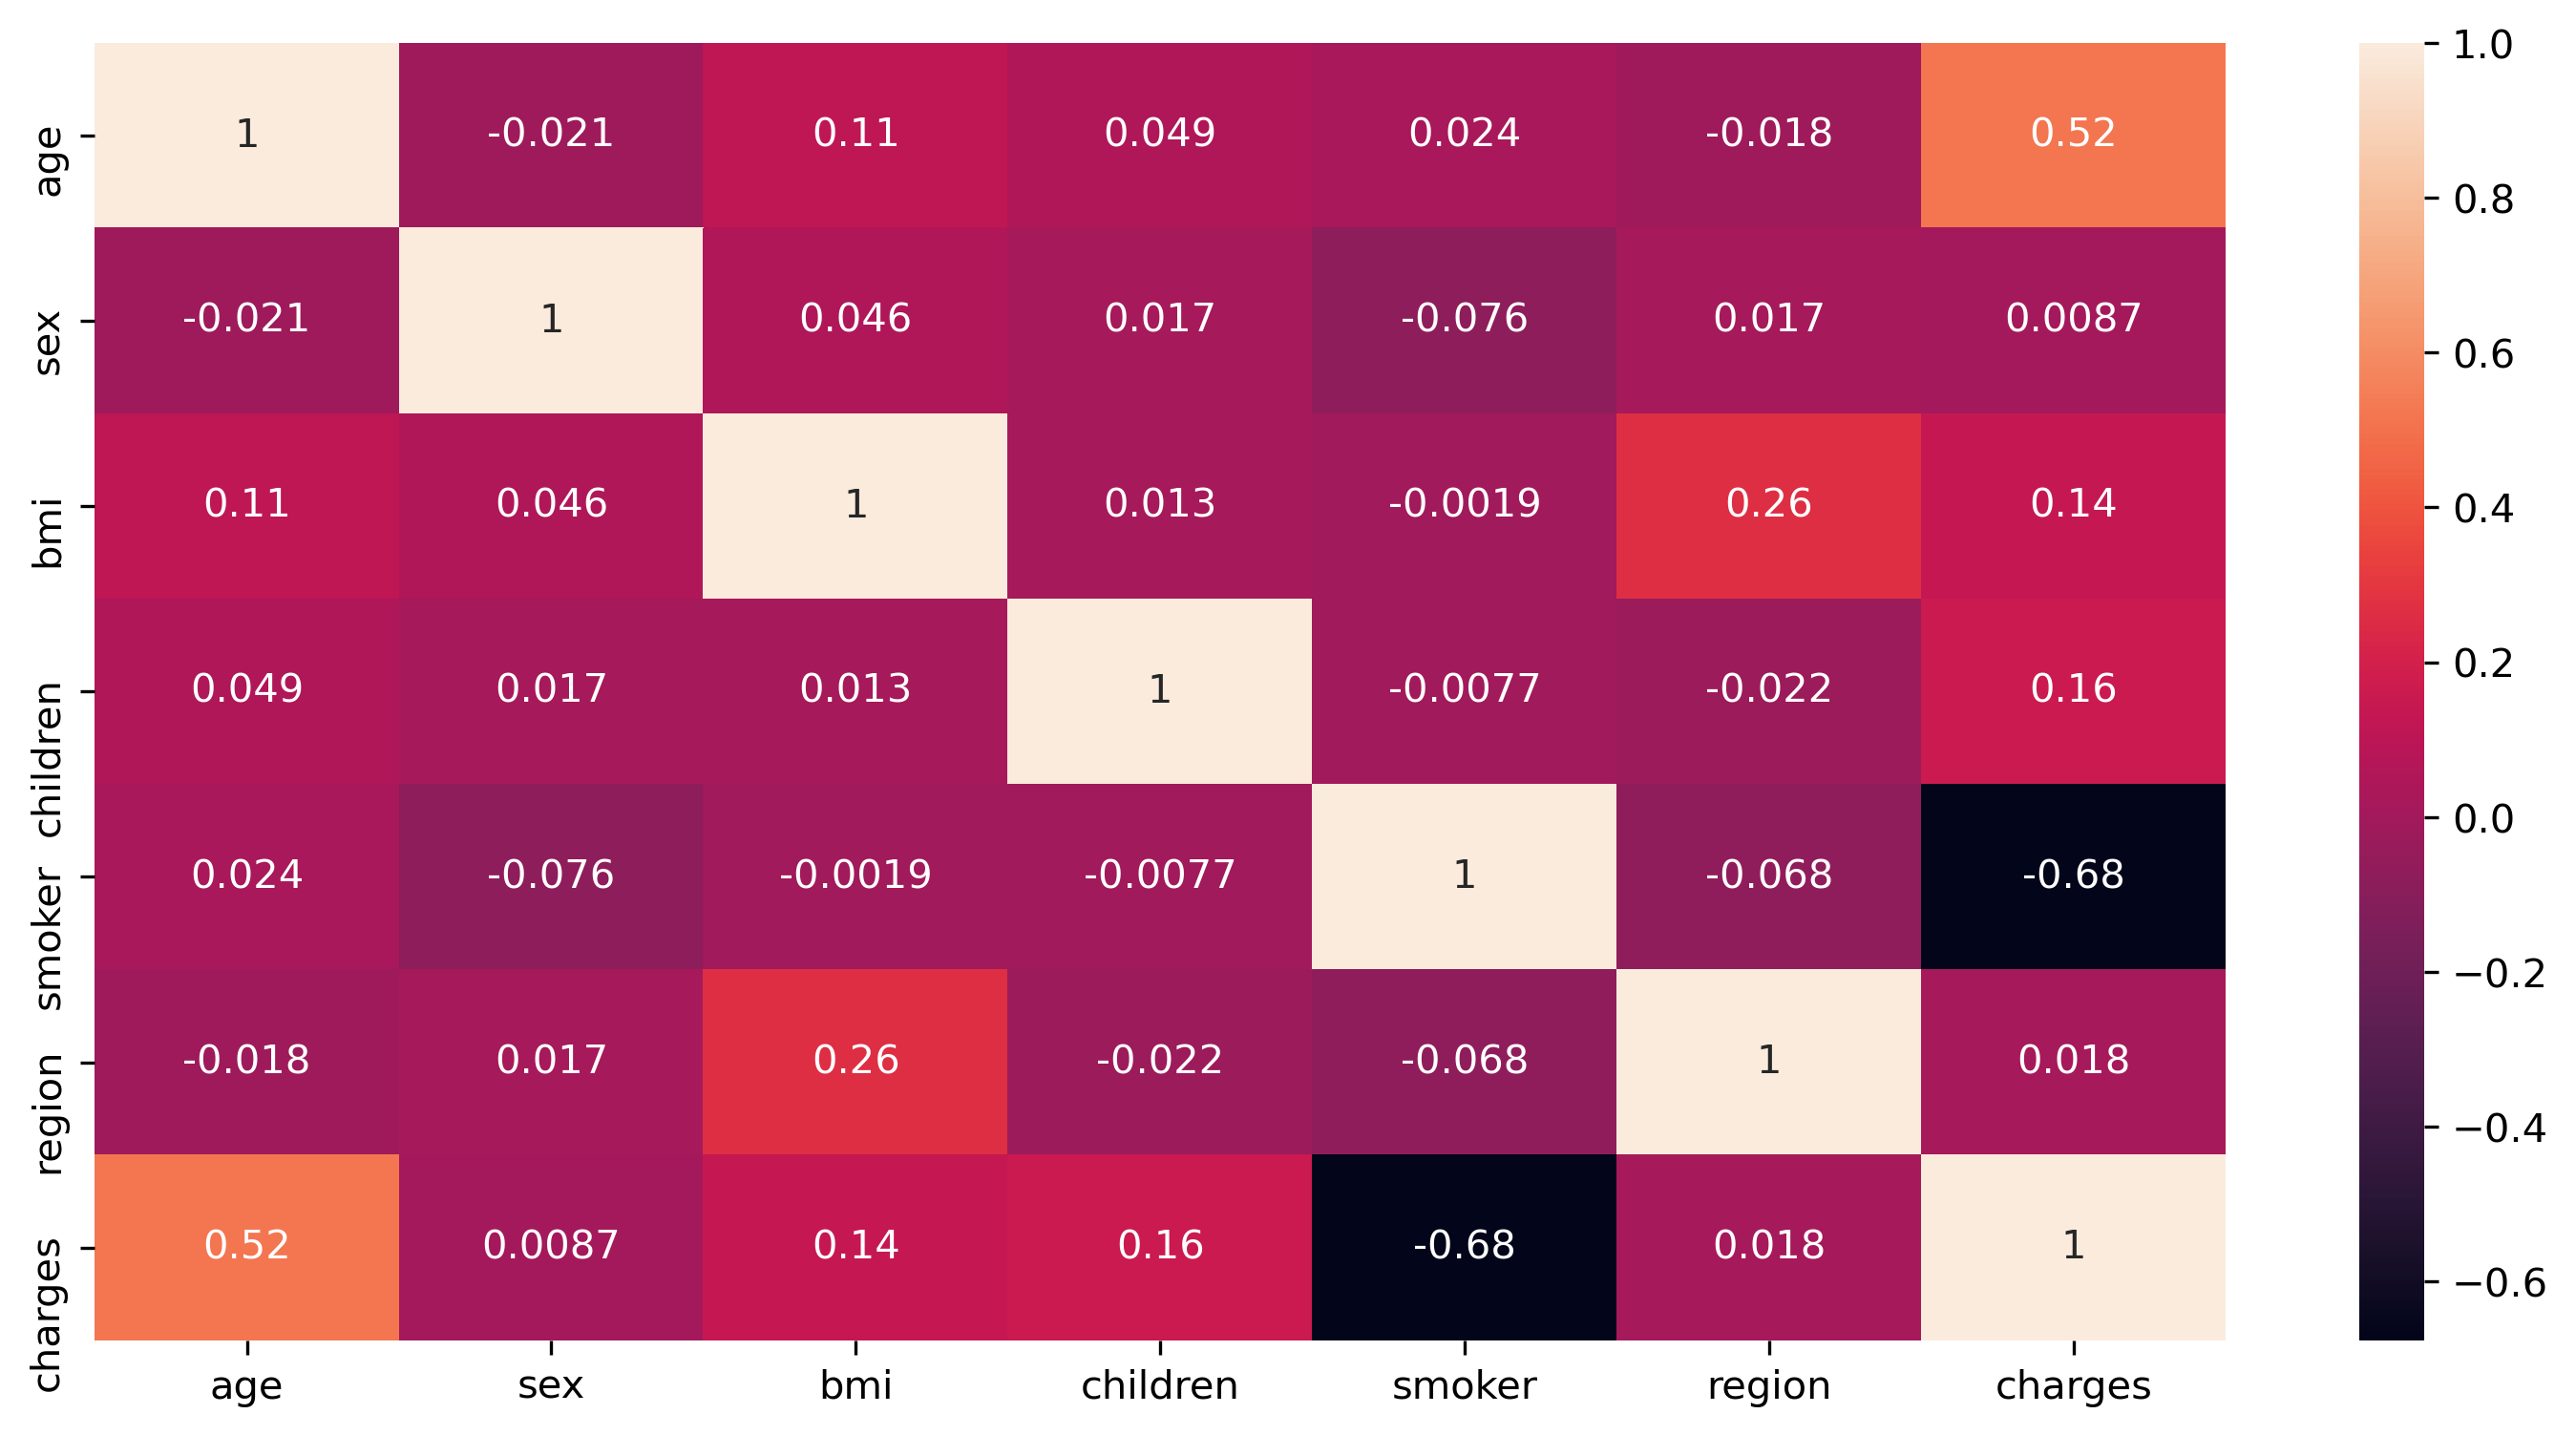

In [52]:
plt.figure(figsize=[12, 6], dpi=300)
sns.heatmap(ins_data.corr(), annot=True, robust=True)
plt.savefig('../../demo/correlation map.png')
plt.show()

In [54]:
df = freg_selection.transform(X)
df = pd.DataFrame(df, columns=['age', 'bmi', 'children', 'smoker'])
df

,age,bmi,children,smoker
0,-0.854167,-0.304319,-0.5,-0.590433
1,-1.020833,0.389592,0.0,0.000000
2,-0.447917,0.302496,1.0,0.000000
3,-0.239583,-0.987437,-0.5,0.000000
4,-0.281250,-0.183343,-0.5,0.000000
...,...,...,...,...
1333,0.468750,0.067477,1.0,0.000000
1334,-1.020833,0.178465,-0.5,0.000000
1335,-1.020833,0.727647,-0.5,0.000000
1336,-0.739583,-0.571484,-0.5,0.000000


## modeling

In [55]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

In [56]:
OLS_model = LinearRegression()

In [58]:
scores = cross_val_score(OLS_model, df, Y, cv=12)
scores

array([0.80262884, 0.78188217, 0.77513224, 0.65769915, 0.69361417,
       0.81418679, 0.8503388 , 0.83383535, 0.77940138, 0.66475726,
       0.63361968, 0.81431229])

In [60]:
print(f'avarage score: {np.mean(scores) * 100}\n'
      f'standard deviation: {np.std(scores)}')

avarage score: 75.84506771788713
standard deviation: 0.07204578323244683


The low standard deviation confirms that this dataset is not much sensitive to the split strategy.
In some cases, the probability distribution of both training and test sets are rather similar,
and in other situations (at least three with 12 folds), they are same; hence, the
algorithm can learn to predict correctly.